In [1]:
#imports
import pandas as pd
import numpy as np
import datetime as dt
from os import listdir
from IPython.display import display
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
import time


#parameters
path = 'C:/Cursos/Become a Data Scientist/Introduction to Data Science/Data/' #path to csv files
pd.set_option('display.max_columns', None) #see all columns of a dataframe

## Business Understanding
1 - What areas generate more revenue?

2 - What kind of properties is best suited for these areas?

3 - Can we predict future revenue?

To discover this, we will explore data from airbnb from boston and seattle

## Data Understanding
Lets take a look into the data to see what kind of information we have

# Downloading the datasets
Download the dataset from:

[https://www.kaggle.com/airbnb/seattle/data](https://www.kaggle.com/airbnb/seattle/data)

[https://www.kaggle.com/airbnb/boston](https://www.kaggle.com/airbnb/boston)

The files of the two cities have the same names, so I renamed for _city (ex: calendar_boston.csv)

* Listings, including full descriptions and average review score

* Reviews, including unique id for each reviewer and detailed comments

* Calendar, including listing id and the price and availability for that day

There is more information about the data here:
http://insideairbnb.com/about.html
and a dictionary here:
https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit#gid=982310896


In [2]:
#importing the data
def import_df(path, prefix, separator='_', col_name='file'):
    '''
    Import all the csv files with the same prefix and concatenate them in the same DF. 
    Create a column with the second splitted element of the separator.
    path = path of the files
    prefix = prefix (name) of the csv files
    separator = the separator of the prefix and the city in the name of the csv
    col_name = name of the column of the splitted element that goes into the dataframe
    '''
    df = pd.DataFrame()
    for file in listdir(path):
        if (file.endswith('.csv') and file.startswith(prefix)):
            df_temp = pd.read_csv(path + file)
            df_temp[col_name] = re.split('_|\.csv', file)[1] #second element of split and remove extension            
            df = pd.concat([df, df_temp], ignore_index=True)
            print('Read file: {}    Shape: {}'.format(file, df_temp.shape))
            
    return df
#gathering the data
df_calendar = import_df(path, 'calendar')
df_listings = import_df(path, 'listings')
df_reviews = import_df(path, 'reviews')

Read file: calendar_boston.csv    Shape: (1308890, 5)
Read file: calendar_seattle.csv    Shape: (1393570, 5)
Read file: listings_boston.csv    Shape: (3585, 96)
Read file: listings_seattle.csv    Shape: (3818, 93)
Read file: reviews_boston.csv    Shape: (68275, 7)
Read file: reviews_seattle.csv    Shape: (84849, 7)


Let's have a quick assesment of the data

In [3]:
df_calendar['date'] = pd.to_datetime(df_calendar['date'])
display(df_calendar.head(3))
df_calendar.groupby(['file']).agg({'date' : [np.min,np.max]}) #see timespan of each file

,listing_id,date,available,price,file
0,12147973,2017-09-05,f,NaN,boston
1,12147973,2017-09-04,f,NaN,boston
2,12147973,2017-09-03,f,NaN,boston


date           
              amin       amax
file                         
boston  2016-09-06 2017-09-05
seattle 2016-01-04 2017-01-02

In [4]:
display(df_listings.head(1))

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,file
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",NaN,"The bus stop is 2 blocks away, and frequent. B...","You will have access to 2 bedrooms, a living r...",NaN,Clean up and treat the home the way you'd like...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,https://a2.muscache.com/im/pictures/c0842db1-e...,31303940,https://www.airbnb.com/users/show/31303940,Virginia,2015-04-15,"Boston, Massachusetts, United States",We are country and city connecting in our deck...,NaN,NaN,NaN,f,https://a2.muscache.com/im/pictures/5936fef0-b...,https://a2.muscache.com/im/pictures/5936fef0-b...,Roslindale,1.0,1.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Birch Street, Boston, MA 02131, United States",Roslindale,Roslindale,NaN,Boston,MA,02131,Boston,"Boston, MA",US,United States,42.282619,-71.133068,t,House,Entire home/apt,4,1.5,2.0,3.0,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",NaN,$250.00,NaN,NaN,NaN,$35.00,1,$0.00,2,1125,2 weeks ago,NaN,0,0,0,0,2016-09-06,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN,boston


In [5]:
df_reviews['date'] = pd.to_datetime(df_reviews['date'])
display(df_reviews.head(3))
df_reviews.groupby(['file']).agg({'date' : [np.min,np.max]}) #see timespan of each file

,listing_id,id,date,reviewer_id,reviewer_name,comments,file
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,boston
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,boston
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,boston


date           
              amin       amax
file                         
boston  2009-03-21 2016-09-06
seattle 2009-06-07 2016-01-03

Lookind at the data, it seems that the boston file was generated on 2016-09-06 and the seattle file was generated on 2016-01-03.
We have several useful information:
* Geographic information such as lat/lon coordinates, street, neighbourhood, city, state, country and zipcode
* Listing characteristics like property_type, room_type and others
* Host characteristics such as host_since, host_total_listings_count, host_has_profile_pic, etc.
* Review scores review_scores_value, review_scores_rating and more


## Data Preparation
We need to clean the data first before trying to answer our question

In [6]:
#Our Boston listing dataframe have 3 more columns than the Seattle one, and 
#both have a lot of columns that we don't need, so get only the columns that 
#are related to our question (location, property characteristics, price and reviews)
listings_cols = ['id', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
                'city', 'state', 'zipcode', 'market', 'smart_location', 'country', 'latitude', 
                'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 
                'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price',
                'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
                'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating',
                'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'file',
                'review_scores_communication', 'review_scores_location', 'review_scores_value', 'cancellation_policy',
                'availability_365', 'calendar_last_scraped', 'availability_30', 'availability_60', 'availability_90']

df_listings = df_listings[listings_cols]

#Diving a little deeper into the data, we can see that we have 3 columns for neighbourhood
#so we will keep only the one with fewer missing values
missing_neighbourhood = df_listings[['neighbourhood','neighbourhood_cleansed', 'neighbourhood_group_cleansed']].count() / df_listings.shape[0]
print('Missing Values froom Neighbourhood Columns:\n{}'.format(missing_neighbourhood))
df_listings.drop(columns=['neighbourhood', 'neighbourhood_group_cleansed'], inplace=True)

#Since there is a lot of  other cities in the "city" and "smart_location" columns, we will replace it by the 
#values of the "file" column and drop it
print('\nCity Unique Values:\n{}'.format(df_listings['city'].unique()))
df_listings['city'] = df_listings['file']
df_listings.drop(columns=['file', 'smart_location'], inplace=True)

#Convert price related columns to number
price_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
df_listings[price_cols] = df_listings[price_cols].replace('[\$,]','', regex=True)
df_listings[price_cols] = df_listings[price_cols].astype(float)


Missing Values froom Neighbourhood Columns:
neighbourhood                   0.870458
neighbourhood_cleansed          1.000000
neighbourhood_group_cleansed    0.515737
dtype: float64

City Unique Values:
['Boston' 'Roslindale' 'Roslindale, Boston' 'Jamaica Plain' 'Brookline'
 'Jamaica Plain, Boston' 'Jamaica Plain (Boston)' 'Roxbury Crossing'
 'Jamaica Plain ' 'Jamaica Plain, MA' 'Boston (Jamaica Plain)'
 'Jamaica plain ' 'ROXBURY CROSSING' 'Mission Hill, Boston' 'boston' '波士顿'
 'Boston, Massachusetts, US' 'South End, Boston' 'Cambridge' 'East Boston'
 'east Boston ' 'Charlestown' 'Boston (Charlestown)' 'Somerville'
 'Watertown' 'Brighton' 'Brighton ' 'Boston ' nan 'West Roxbury' 'Newton'
 'Hyde Park' 'Mattapan' 'Milton' 'Dorchester' 'dorchester, boston '
 'South Boston' 'Allston' 'ALLSTON' 'Seattle' 'Ballard, Seattle'
 'West Seattle' 'Seattle ' '西雅图' 'Phinney Ridge Seattle' 'seattle']


In [7]:
#The reviews dataframe is a little easier, let just keep the columns that we want.
#The comments column have very useful information, but since we won't do any text analysis 
#we won't keep it
reviews_cols = ['listing_id', 'id', 'date', 'reviewer_id', 'file']
df_reviews = df_reviews[reviews_cols]

#And rename the "file" for "city" also
df_reviews.rename(columns={'file' : 'city'}, inplace=True)

In [8]:
#For the calendar, we will convert the "available" flag for 1(true) and 0(false)
df_calendar['available'] = (df_calendar['available'] == 't')*1

#And rename the "file" for "city" also
df_calendar.rename(columns={'file' : 'city'}, inplace=True)

### Calculating occupancy

Inside Airbnb have an occupancy model that we will replicate, it consist mainly of these 3 characteristics:

* **Convert review rate to estimated booking**

Accordingly with Airbnb, 72% of the bookings leave reviews, the Budget and Legislative Analyst's Office made their analysis with this value in addition to other of 30.5%. We will go with Inside Airbnb and consider that 50% of the bookings lead to reviews

* **Avarage length of stay**

We will consider an avarage length of stay of 3 days. If the minimum nights of a listing is higher, then this value is used

* **Occupancy rate was capped at 70%**


font: http://insideairbnb.com/about.html

In [9]:
df_booking = df_reviews.copy()
df_booking['month'] = pd.DatetimeIndex(df_booking['date']).month
df_booking['year'] = pd.DatetimeIndex(df_booking['date']).year
df_booking['days_in_month'] = pd.DatetimeIndex(df_booking['date']).daysinmonth
df_booking = df_booking.groupby(['listing_id', 'city', 'month', 'year', 'days_in_month'],
                                as_index=False).agg({'id' : 'count'})
df_booking.rename(columns={'id' : 'reviews'}, inplace=True)
df_booking['booking'] = df_booking['reviews'] * 2 #only 50% leave reviews


df_listings2 = df_listings[['id', 'neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 
                            'bathrooms', 'bedrooms', 'beds', 'bed_type', 'square_feet', 'price', 'cancellation_policy',
                            'minimum_nights']]
df_revenue = df_booking.merge(df_listings2, how='left', left_on='listing_id', right_on='id')
df_revenue['minimum_nights'].where(df_revenue['minimum_nights'] > 3, 3, inplace=True)
df_revenue['max_days'] = df_booking['days_in_month'] * 0.7 #capped occupancy
df_revenue['days'] = df_revenue['booking'] * df_revenue['minimum_nights']
df_revenue['days'] = df_revenue[['days', 'max_days']].min(axis=1)                         
df_revenue['occupancy_rate'] = df_revenue['days'] / df_booking['days_in_month']
df_revenue['estimated_revenue'] = df_revenue['days'] * df_revenue['price']

### Analysing the data to answer questions 1 and 2
Visualizing the data

In [10]:
def plot_revenue_neighbourhood(year = None):
    '''
    Plot stacked barchart of Top 10 Seattle and Boston Neighbourhood by Property Type
    year = filter specific year, if nothing is passed it doesn't filter any year
    '''

    if year is not None:
        df_filtered = df_revenue[df_revenue['year'] == year]
        year_title = year
    else:
        df_filtered = df_revenue
        year_title = 'All Years'
        
    df_revenue_plot = df_filtered.groupby(['neighbourhood_cleansed', 'city', 'property_type'
                                         ]).agg({'estimated_revenue' : 'sum', 'listing_id' : 'count'})
    df_revenue_plot.rename(columns={'listing_id' : 'listing_quantity'}, inplace=True)
    df_revenue_plot.reset_index(inplace=True)

    #ranking and top 10 for each city
    df_revenue_temp = df_filtered.groupby(['neighbourhood_cleansed', 'city'
                                         ]).agg({'estimated_revenue' : 'sum'})
    df_revenue_temp.reset_index(inplace=True)
    df_revenue_temp.sort_values('estimated_revenue', ascending=False, inplace=True)
    df_revenue_temp['rank'] = df_revenue_temp.groupby(['city'])['estimated_revenue'].rank(ascending=False, method='dense')
    df_revenue_temp.drop(columns=['estimated_revenue'], inplace=True)
    df_revenue_plot = df_revenue_plot.merge(df_revenue_temp, how='left', on=['city','neighbourhood_cleansed'])
    df_revenue_plot.sort_values('rank', inplace=True)

    df_revenue_plot_boston = df_revenue_plot[(df_revenue_plot['city'] == 'boston') & (df_revenue_plot['rank'] <= 10)]
    df_revenue_plot_seattle = df_revenue_plot[(df_revenue_plot['city'] == 'seattle') & (df_revenue_plot['rank'] <= 10)]

    #get xlabels
    boston_labels = list(df_revenue_plot_boston['neighbourhood_cleansed'].drop_duplicates())
    seattle_labels = list(df_revenue_plot_seattle['neighbourhood_cleansed'].drop_duplicates())

    df_pivot_boston = df_revenue_plot_boston.pivot_table(index=['rank'], columns=['property_type'],
                                      values=['estimated_revenue'], fill_value=0, aggfunc='sum', margins=True)
    df_pivot_boston.sort_values(by='All', ascending=False, axis=1, inplace=True) #sort columns by total value 
    df_pivot_boston.drop(columns=['All'], level=1, inplace=True)
    df_pivot_boston.drop('All', axis=0, inplace=True)
    df_pivot_boston = df_pivot_boston.droplevel(0,axis=1)

    df_pivot_seattle = df_revenue_plot_seattle.pivot_table(index=['rank'], columns=['property_type'],
                                      values=['estimated_revenue'], fill_value=0, aggfunc='sum', margins=True)
    df_pivot_seattle.sort_values(by='All', ascending=False, axis=1, inplace=True)
    df_pivot_seattle.drop(columns=['All'], level=1, inplace=True)
    df_pivot_seattle.drop('All', axis=0, inplace=True)
    df_pivot_seattle = df_pivot_seattle.droplevel(0,axis=1)


    #plotting
    fig, ax = plt.subplots(1,2, figsize=(15,7), sharey=True)

    df_pivot_seattle.plot.bar(stacked=True, ax=ax[0], legend=True, colormap='tab20')
    df_pivot_boston.plot.bar(stacked=True, ax=ax[1], legend=False, colormap='tab20')


    #adjusting appearance and labels
    ax[0].legend()
    ax[1].legend()
    ax[0].set_xticklabels(seattle_labels, rotation=70, fontsize=11)
    ax[1].set_xticklabels(boston_labels, rotation=70, fontsize=11)
    ax[0].set_ylabel('Estimated Revenue in Million USD', fontsize=13)
    ax[0].set_xlabel('Neighbourhood', fontsize=13)
    ax[1].set_xlabel('')
    ax[0].set_title('Seattle by Property Type', fontsize=16)
    ax[1].set_title('Boston by Property Type', fontsize=16)
    ax[0].xaxis.set_label_coords(1.05, -0.3)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    fig.suptitle('Top 10 Neighbourhood ' + str(year_title), fontsize=20)

    plt.tight_layout()
    plt.show()

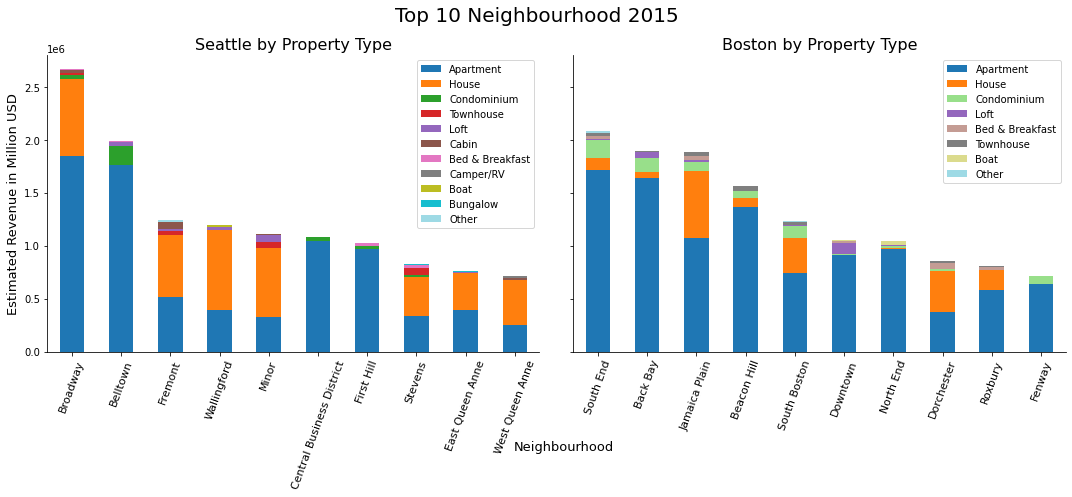

In [11]:
#answering question 1:
#lets see a 2015 comparison since is the last full year of both cities
plot_revenue_neighbourhood(2015)

Here we can see that Broadway is the leader with it’s estimated revenue above 2.5 million USD followed by South End.

We can identify that Seattle’s revenue is concentrated in two main neighbourhoods, Boston on the other hand is a little more uniformly distributed.

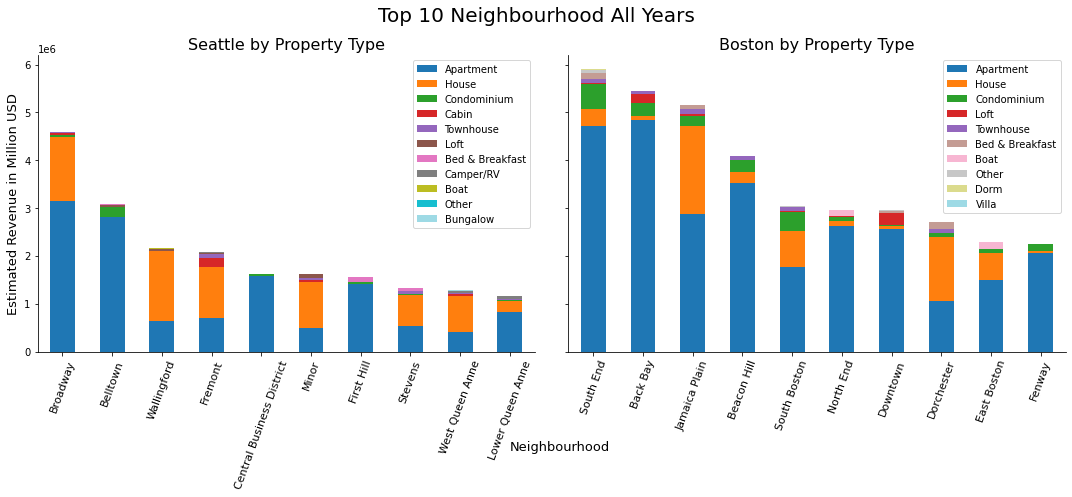

In [12]:
#and for all years
plot_revenue_neighbourhood()

This indicates to us that Boston has proably had a headstart with Airbnb rentals comparing with Seattle, since most of the neighbourhoods have a larger estimated revenue

In [13]:
def top_neighbourhood(year = None):
    '''
    Return DataFrame with top 10 neighbourhood and the top 1 property type for each city
    year = filter specific year, if nothing is passed it doesn't filter any year
    '''
    if year is not None:
        df_filtered = df_revenue[df_revenue['year'] == year]
        year_title = year
    else:
        df_filtered = df_revenue
        year_title = 'All Years'

    df_neighbourhood = df_filtered.groupby(['neighbourhood_cleansed', 'city', 'property_type'
                                             ]).agg({'estimated_revenue' : 'sum', 'listing_id' : 'count'})
    df_neighbourhood.rename(columns={'listing_id' : 'listing_quantity'}, inplace=True)
    df_neighbourhood.reset_index(inplace=True)

    #ranking for each city and top 10
    df_neighbourhood_temp = df_filtered.groupby(['neighbourhood_cleansed', 'city'
                                         ]).agg({'estimated_revenue' : 'sum'})
    df_neighbourhood_temp.reset_index(inplace=True)
    df_neighbourhood_temp.sort_values('estimated_revenue', ascending=False, inplace=True)
    df_neighbourhood_temp['rank'] = df_neighbourhood_temp.groupby(['city'])['estimated_revenue'].rank(ascending=False, method='dense')
    df_neighbourhood_temp.drop(columns=['estimated_revenue'], inplace=True)
    df_neighbourhood = df_neighbourhood.merge(df_neighbourhood_temp, how='left', on=['city','neighbourhood_cleansed'])
    df_neighbourhood.sort_values('rank', inplace=True)

    df_neighbourhood_boston = df_neighbourhood[(df_neighbourhood['city'] == 'boston') & (df_neighbourhood['rank'] <= 10)]
    df_neighbourhood_seattle = df_neighbourhood[(df_neighbourhood['city'] == 'seattle') & (df_neighbourhood['rank'] <= 10)]

    idx_boston = df_neighbourhood_boston.groupby(['neighbourhood_cleansed', 'city'])['estimated_revenue'].transform(max) == df_neighbourhood_boston['estimated_revenue']
    df_neighbourhood_boston = df_neighbourhood_boston[idx_boston]
    df_neighbourhood_boston.drop(columns=['city'], inplace=True)
    df_neighbourhood_boston['Average Revenue'] = (df_neighbourhood_boston['estimated_revenue']
                                                   / df_neighbourhood_boston['listing_quantity']).map('${:,.2f}'.format)
    df_neighbourhood_boston['estimated_revenue'] = df_neighbourhood_boston['estimated_revenue'].map('${:,.2f}'.format)
    df_neighbourhood_boston.rename(columns={'neighbourhood_cleansed' : 'Boston Neighbourhood', 
                                            'property_type' : 'Boston Property Type',
                                            'estimated_revenue' : 'Boston Estimated Revenue',
                                            'listing_quantity' : 'Boston Listing Quantity',
                                            'Average Revenue' : 'Boston Average Revenue',
                                            'rank' : 'Rank ' + str(year_title)}, inplace=True)
    df_neighbourhood_boston.set_index('Rank ' + str(year_title), inplace=True)


    idx_seattle = df_neighbourhood_seattle.groupby(['neighbourhood_cleansed', 'city'])['estimated_revenue'].transform(max) == df_neighbourhood_seattle['estimated_revenue']
    df_neighbourhood_seattle = df_neighbourhood_seattle[idx_seattle]
    df_neighbourhood_seattle.drop(columns=['city'], inplace=True)
    df_neighbourhood_seattle['Average Revenue'] = (df_neighbourhood_seattle['estimated_revenue']
                                                   / df_neighbourhood_seattle['listing_quantity']).map('${:,.2f}'.format)
    df_neighbourhood_seattle['estimated_revenue'] = df_neighbourhood_seattle['estimated_revenue'].map('${:,.2f}'.format)
    df_neighbourhood_seattle.rename(columns={'neighbourhood_cleansed' : 'Seattle Neighbourhood', 
                                            'property_type' : 'Seattle Property Type',
                                            'estimated_revenue' : 'Seattle Estimated Revenue',
                                            'listing_quantity' : 'Seattle Listing Quantity',
                                            'Average Revenue' : 'Seattle Average Revenue',
                                            'rank' : 'Rank ' + str(year_title)}, inplace=True)
    df_neighbourhood_seattle.set_index('Rank ' + str(year_title), inplace=True)


    df_neighbourhood_return = pd.concat([df_neighbourhood_seattle, df_neighbourhood_boston], axis=1)
    
    return df_neighbourhood_return

In [14]:
#answering question 2:
#getting the top property type for 2015
top_neighbourhood(2015)

,Seattle Neighbourhood,Seattle Property Type,Seattle Estimated Revenue,Seattle Listing Quantity,Seattle Average Revenue,Boston Neighbourhood,Boston Property Type,Boston Estimated Revenue,Boston Listing Quantity,Boston Average Revenue
Rank 2015,,,,,,,,,,
1.0,Broadway,Apartment,"$1,848,677.40",1080,"$1,711.74",South End,Apartment,"$1,719,256.60",658,"$2,612.85"
2.0,Belltown,Apartment,"$1,765,778.20",887,"$1,990.73",Back Bay,Apartment,"$1,636,893.00",491,"$3,333.79"
3.0,Fremont,House,"$580,765.90",343,"$1,693.20",Jamaica Plain,Apartment,"$1,074,003.40",592,"$1,814.19"
4.0,Wallingford,House,"$756,442.10",469,"$1,612.88",Beacon Hill,Apartment,"$1,367,583.00",480,"$2,849.13"
5.0,Minor,House,"$653,767.80",408,"$1,602.37",South Boston,Apartment,"$739,901.60",259,"$2,856.76"
6.0,Central Business District,Apartment,"$1,042,379.80",431,"$2,418.51",Downtown,Apartment,"$915,438.10",262,"$3,494.04"
7.0,First Hill,Apartment,"$966,235.00",483,"$2,000.49",North End,Apartment,"$967,786.90",376,"$2,573.90"
8.0,Stevens,House,"$360,977.50",251,"$1,438.16",Dorchester,House,"$387,348.80",315,"$1,229.68"
9.0,East Queen Anne,Apartment,"$395,816.40",230,"$1,720.94",Roxbury,Apartment,"$581,389.40",277,"$2,098.88"


In [15]:
#and for all years
top_neighbourhood()

,Seattle Neighbourhood,Seattle Property Type,Seattle Estimated Revenue,Seattle Listing Quantity,Seattle Average Revenue,Boston Neighbourhood,Boston Property Type,Boston Estimated Revenue,Boston Listing Quantity,Boston Average Revenue
Rank All Years,,,,,,,,,,
1.0,Broadway,Apartment,"$3,144,787.60",1822,"$1,726.01",South End,Apartment,"$4,708,393.00",1723,"$2,732.67"
2.0,Belltown,Apartment,"$2,821,519.00",1479,"$1,907.72",Back Bay,Apartment,"$4,841,189.70",1579,"$3,065.98"
3.0,Wallingford,House,"$1,478,477.20",941,"$1,571.18",Jamaica Plain,Apartment,"$2,869,693.20",1665,"$1,723.54"
4.0,Fremont,House,"$1,066,043.50",606,"$1,759.15",Beacon Hill,Apartment,"$3,523,230.70",1253,"$2,811.84"
5.0,Central Business District,Apartment,"$1,582,019.40",712,"$2,221.94",South Boston,Apartment,"$1,774,110.30",665,"$2,667.84"
6.0,Minor,House,"$954,122.50",649,"$1,470.14",North End,Apartment,"$2,627,530.90",1008,"$2,606.68"
7.0,First Hill,Apartment,"$1,417,438.50",740,"$1,915.46",Downtown,Apartment,"$2,565,359.10",756,"$3,393.33"
8.0,Stevens,House,"$651,112.80",438,"$1,486.56",Dorchester,House,"$1,331,905.70",1122,"$1,187.08"
9.0,West Queen Anne,House,"$766,552.50",258,"$2,971.13",East Boston,Apartment,"$1,501,727.40",697,"$2,154.56"


### Now lets see if we can create a model to predict future revenue

For this, we need to modify our dataset to include our main features that contribute to the prediction

our target variable will be the estimated_revenue

In [16]:
df_revenue_ml = df_revenue.drop(columns=['listing_id', 'id', 'occupancy_rate', 'reviews', 'booking']) #we won't have occupancy rate, reviews or booking for new listings

#dealing with missing data
print('Columns missing count: \n{}'.format(df_revenue_ml.isnull().sum()))
print('\nSquare_feet % of missing: {:.2f}'.format(df_revenue_ml['square_feet'].isnull().sum()  / df_revenue_ml.shape[0]))
#since only 5% of the square_feet have data, we will drop it
df_revenue_ml.drop(columns=['square_feet'], inplace=True)
#for property_type, we will create e new classification "not_specified"
df_revenue_ml['property_type'].fillna('Not Specified', inplace=True)
#filling the na for bathrooms with the mean considering property type
#we are filling this way because different properties may have different means
#for example, is very likely that a house have more bathrooms than an camper, so
#by doing this we tend to preserve the features differences between them and still 
#keep it simple to do and understand
bathroom_dict = df_revenue_ml[['property_type', 'bathrooms']].groupby(['property_type']).median()['bathrooms'].to_dict()
df_revenue_ml['bathrooms'].fillna(df_revenue_ml['property_type'].map(bathroom_dict), inplace=True)
#same for bedrooms
bedroom_dic = df_revenue_ml[['property_type', 'bedrooms']].groupby(['property_type']).median()['bedrooms'].to_dict()
df_revenue_ml['bedrooms'].fillna(df_revenue_ml['property_type'].map(bedroom_dic), inplace=True)
#and for beds
beds_dic = df_revenue_ml[['property_type', 'beds']].groupby(['property_type']).median()['beds'].to_dict()
df_revenue_ml['beds'].fillna(df_revenue_ml['property_type'].map(beds_dic), inplace=True)
#verifying if all missing values have been filled
print('\nColumns missing count after filling: \n{}'.format(df_revenue_ml.isnull().sum()))

Columns missing count: 
city                          0
month                         0
year                          0
days_in_month                 0
neighbourhood_cleansed        0
property_type                13
room_type                     0
accommodates                  0
bathrooms                   534
bedrooms                    188
beds                         40
bed_type                      0
square_feet               46508
price                         0
cancellation_policy           0
minimum_nights                0
max_days                      0
days                          0
estimated_revenue             0
dtype: int64

Square_feet % of missing: 0.95

Columns missing count after filling: 
city                      0
month                     0
year                      0
days_in_month             0
neighbourhood_cleansed    0
property_type             0
room_type                 0
accommodates              0
bathrooms                 0
bedrooms                  0
beds

In [17]:
#dealing with categorical data
print('Columns type: \n{}'.format(df_revenue_ml.dtypes))

#for each categorical data column (object type) we will do a hot encode (create a column for each value of each column)
print('\nNumber of columns to be create: \n{}'.format(df_revenue_ml.select_dtypes('object').nunique()))
#since is not a huge amount of columns, we are good to go

cat_list = list(df_revenue_ml.select_dtypes('object').columns)
df_revenue_ml_encoded =  pd.get_dummies(df_revenue_ml, prefix=cat_list, columns=cat_list)
print('\nDataframe hot encoded shape: {}'.format(df_revenue_ml_encoded.shape))
    

Columns type: 
city                       object
month                       int64
year                        int64
days_in_month               int64
neighbourhood_cleansed     object
property_type              object
room_type                  object
accommodates                int64
bathrooms                 float64
bedrooms                  float64
beds                      float64
bed_type                   object
price                     float64
cancellation_policy        object
minimum_nights              int64
max_days                  float64
days                      float64
estimated_revenue         float64
dtype: object

Number of columns to be create: 
city                        2
neighbourhood_cleansed    111
property_type              20
room_type                   3
bed_type                    5
cancellation_policy         4
dtype: int64

Dataframe hot encoded shape: (48888, 157)


## Modeling

Now its time to model our algorithm

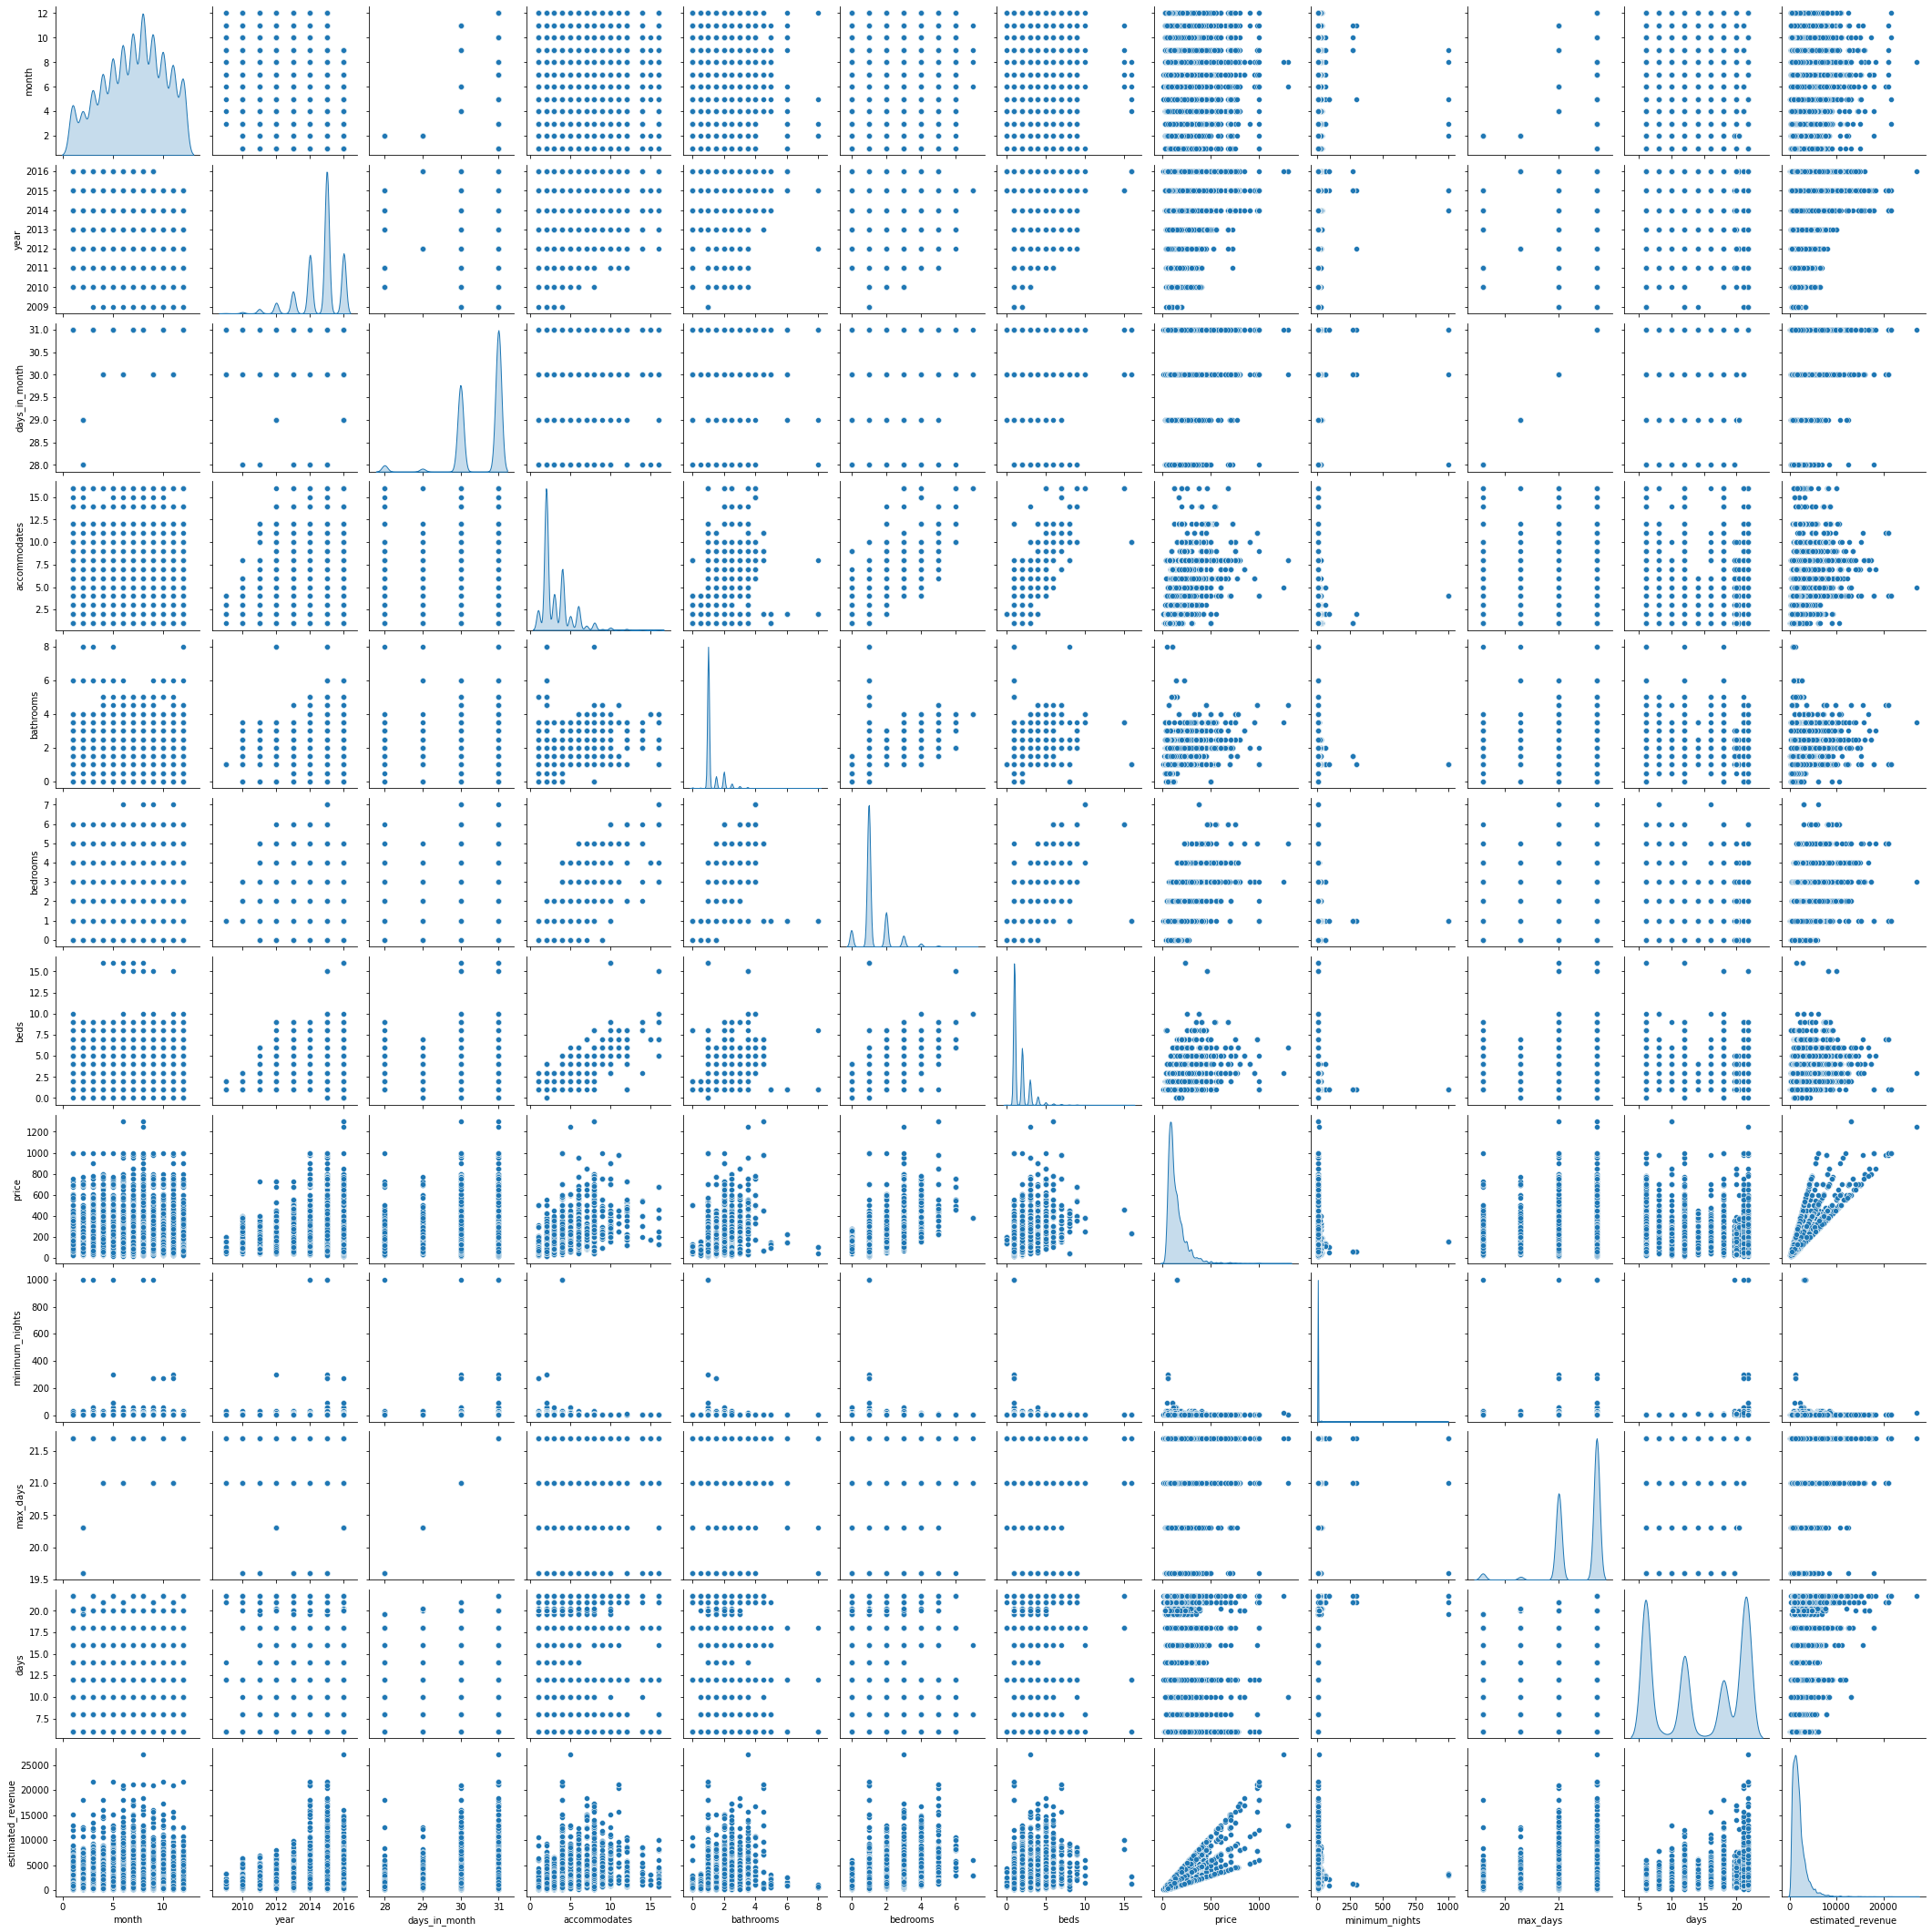

In [18]:
#lets take a look in the correlations
fig = sns.pairplot(df_revenue_ml, diag_kind='kde')
plt.show()

In [19]:
#splitting the data
X = df_revenue_ml_encoded.drop(columns=['estimated_revenue'])
y = df_revenue_ml_encoded['estimated_revenue']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.3, random_state=0)


def grid_lasso():
    '''
    Does a grid search to optimze hyperparameters of the Lasso regression, return the best hyperparameters, the
    mean score and mean time to fit
    '''
    #GridSearch
    grid_values = {'alpha' : [0.01, 0.1, 1, 10, 100],
                   'warm_start' : [True, False],
                   'positive' : [True, False],
                   'selection' : ['cyclic', 'random']}
    scoring = 'r2'
    ncv = 3

    lasso = Lasso(random_state=0)
    grid_lasso = GridSearchCV(lasso, param_grid=grid_values, scoring=scoring, cv=ncv).fit(X_train, y_train)
    df_grid = pd.DataFrame(grid_lasso.cv_results_)
    df_grid = df_grid[['mean_fit_time', 'param_alpha','param_positive','param_selection',
                       'param_warm_start','mean_test_score']]
    df_grid.sort_values('mean_test_score', ascending=False, inplace=True)
    df_grid = df_grid.iloc[0]
    
    return df_grid

def grid_ridge():
    '''
    Does a grid search to optimze hyperparameters of the Lasso regression, return the best hyperparameters, the
    mean score and mean time to fit
    '''
    #GridSearch
    grid_values = {'alpha' : [0.01, 0.1, 1, 10, 100],
                   'solver' : ['auto', 'svd', 'cholesky', 'sparse_cg', 'lsqr', 'sag', 'saga']}
    scoring = 'r2'
    ncv = 3

    ridge = Ridge(random_state=0)
    grid_ridge = GridSearchCV(ridge, param_grid=grid_values, scoring=scoring, cv=ncv).fit(X_train, y_train)
    df_grid = pd.DataFrame(grid_ridge.cv_results_)
    df_grid = df_grid[['mean_fit_time', 'param_alpha', 'param_solver', 'mean_test_score']]
    df_grid.sort_values('mean_test_score', ascending=False, inplace=True)
    df_grid = df_grid.iloc[0]
    
    return df_grid

lasso_gs = grid_lasso()
print('Lasso gridsearch results:\n{}'.format(lasso_gs))
ridge_gs = grid_ridge()
print('Ridge gridsearch results:\n{}'.format(ridge_gs))


C:\Users\gfmar\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6302554.450791359, tolerance: 5157218.993256635
  positive)
C:\Users\gfmar\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6302554.450791359, tolerance: 5157218.993256635
  positive)
C:\Users\gfmar\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1753397702.4457293, tolerance: 5157218.993256635
  positive)
C:\Users\gfmar\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Lasso gridsearch results:
mean_fit_time       0.969095
param_alpha              0.1
param_positive         False
param_selection       random
param_warm_start       False
mean_test_score     0.850519
Name: 15, dtype: object
Ridge gridsearch results:
mean_fit_time      0.077236
param_alpha              10
param_solver       cholesky
mean_test_score    0.850441
Name: 23, dtype: object


In [20]:
#training and predicting with lasso
start_lasso = time.time()
lasso = Lasso(alpha=0.1, positive=False, selection='random',
              warm_start=False, random_state=0).fit(X_train, y_train)
y_predict_train_lasso = lasso.predict(X_train)
y_predict_lasso = lasso.predict(X_test)
end_lasso = time.time()
print('Lasso Duration: {}'.format(end_lasso - start_lasso))

#training and predicting with Ridge
start_ridge = time.time()
ridge = Ridge(alpha=10, solver='cholesky', random_state=0).fit(X_train, y_train)
y_predict_train_ridge = ridge.predict(X_train)
y_predict_ridge = ridge.predict(X_test)
end_ridge = time.time()
print('Ridge Duration: {}'.format(end_ridge - start_ridge))

Lasso Duration: 0.5944063663482666
Ridge Duration: 0.11015677452087402


## Evaluation

In [21]:
print('Lasso Evaluation:')
#using r2_score to evaluate performance
r2_train = r2_score(y_train, y_predict_train_lasso)
r2_test = r2_score(y_test, y_predict_lasso)
print('R2 train score: {}\nR2 test score: {}'.format(r2_train, r2_test))

#using cross validation to estimate scores
cv_scores = cross_val_score(lasso, X, y, cv=5, scoring='r2')
print('Cross Validation R2 mean: {}\nCross Validation R2 standard deviation: {}'.format(cv_scores.mean(),cv_scores.std()))


print('\nRidge Evaluation:')
#using r2_score to evaluate performance
r2_train_ridge = r2_score(y_train, y_predict_train_ridge)
r2_test_ridge = r2_score(y_test, y_predict_ridge)
print('R2 train score: {}\nR2 test score: {}'.format(r2_train_ridge, r2_test_ridge))

#using cross validation to estimate scores
cv_scores_ridge = cross_val_score(ridge, X, y, cv=5, scoring='r2')
print('Cross Validation R2 mean: {}\nCross Validation R2 standard deviation: {}'.format(cv_scores_ridge.mean(),cv_scores_ridge.std()))

Lasso Evaluation:
R2 train score: 0.85156950972085
R2 test score: 0.8470433348956904
Cross Validation R2 mean: 0.8350424187389971
Cross Validation R2 standard deviation: 0.020411665666851028

Ridge Evaluation:
R2 train score: 0.851689295982942
R2 test score: 0.8471187077080635
Cross Validation R2 mean: 0.834778600016311
Cross Validation R2 standard deviation: 0.020414035609031635
